# Детекция объектов

Данные - датасет по кадрам игры в квиддич из Гарри Поттера. Если вы забыли правила, то нажмите [сюда](https://harrypotter.fandom.com/ru/wiki/%D0%9A%D0%B2%D0%B8%D0%B4%D0%B4%D0%B8%D1%87). Научим модель искать и выделять на фотографиях бладжеры, квоффл и снитч.

## Данные

Разметка находится в xmls папке, картинки в images.

In [ ]:
# Harry Potter -- uncomment
!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip


!unzip -q data.zip

--2023-12-10 11:02:35--  https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/harry/data.zip [following]
--2023-12-10 11:02:36--  https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/harry/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17592727 (17M) [application/zip]
Saving to: ‘data.zip.1’

data.zip.1          100%[===================>]  16.78M  --.-KB/s    in 0.1s    

2023-12-10 11:02:36 (122 MB/s) - ‘data.zip.1’ saved [17592727/17592727]

replace data/class_dict? [y]es, [n]o, [A]ll

# Шаг 1. Загрузка данных


In [ ]:
import torch
from xml.etree import ElementTree as ET
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from pathlib import Path
import glob
import numpy as np
from PIL import Image
import torchvision
from torchvision.models import ResNet50_Weights
from tqdm.notebook import tqdm
from torch import nn
import shutil
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.patches import Rectangle

Функции передадим некий class_dict. Он есть и при инициализации датасета ниже. С его помощью название класса превратим в int

In [ ]:
def get_xml_data(image_name, root, class_dict, xml_prefix="/xmls/"):
    # get smth like ZZZ/YYY/XXXXXX.jpg -> XXXXXX
    filename = image_name.split("/")[-1].split(".")[0]
    # read xml
    tree = ET.parse(str(root) + xml_prefix + filename + ".xml")
    treeroot = tree.getroot()
    # iterate over bboxes
    bboxes = []
    for member in treeroot.findall("object"):
        # xmin ymin xmax ymax, class in dict
        res = [int(member.find("bndbox/xmin").text), int(member.find("bndbox/ymin").text), int(member.find("bndbox/xmax").text),
               int(member.find("bndbox/ymax").text), class_dict[member.find("name").text]]
        bboxes.append(res)

    return bboxes

In [ ]:
class PascalDataset(torch.utils.data.Dataset):
    def __init__(self, *, transform, root="dataset", train=True, seed=42):
        self.root = Path(root)
        self.transform = transform

        assert self.root.is_dir(), f"No data at `{root}`"

        self.filenames = np.array(glob.glob(root + "/images/*"))
        with open(str(self.root) + "/class_dict", "r") as f:
            self.class_dict = eval(f.readline())

        self.class_dict_inv = {v: k for k, v in self.class_dict.items()}

        np.random.seed(seed)
        permutation = np.random.permutation(len(self.filenames))

        # Train/test split
        if train:
            self.filenames = self.filenames[
                permutation[: int(len(self.filenames) * 0.9)]
            ].tolist()
        else:
            self.filenames = self.filenames[
                permutation[int(len(self.filenames) * 0.9) :]
            ].tolist()

    def __getitem__(self, idx):
        fname = self.filenames[idx] # получаем filename из filenames
        image = plt.imread(fname) # по названию файла загружаем картинку
        bboxes = self.__get_raw_item__(idx)[1] # получаем координаты и класс, пользуясь ранее написанной функцией
        bboxes = torch.tensor(bboxes, dtype=torch.float32) # переводим координаты и класс из словаря в тензор

        return self.transform(image=image, bboxes=bboxes)

    def __get_raw_item__(self, idx):
        fname = self.filenames[idx]
        return fname, get_xml_data(fname, self.root, self.class_dict)

    def __len__(self):
        return len(self.filenames)

Ниже определяем стандартные нормализации и приведение размера к 512x512.


In [ ]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.3),
)

test_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.5),
)

In [ ]:
train_ds = PascalDataset(root="./data/", transform=train_transform, train=True)
test_ds = PascalDataset(root="./data/", transform=test_transform, train=False)

# Шаг 2. Визуализация данных

Напишем функцию `visualize`, которая принимает списки изображений и прямоугольников в качестве входных данных и рисует эти прямоугольники на изображениях

In [ ]:
def visualize(images, bboxes):
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    fig, axes = plt.subplots(
        2, len(images) // 2 + len(images) % 2, figsize=(10, 8), dpi=100
    )

    for i, ax in enumerate(axes.reshape(-1)):

        ax.axis(False)

        if i >= len(images):
            break
        image = images[i].permute(1, 2, 0).numpy() # переставляем, чтобы было (n_channels, height, batch_size) вместо
        # (batch_size, n_channels, height, width), как принято в PyTorch
        image = std * image + mean # откатываем нормализацию
        image = np.clip(image, 0, 1)

        ax.imshow(image)

        # добавляем на картинку квадратики детекции
        for bbox in bboxes[i]:
          kvadratek = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], lw=1, edgecolor="red", facecolor="none")
          ax.add_patch(kvadratek)
          # и просим подписать, что нашлось в квадратике
          ax.text(bbox[0],bbox[1], # указываем где писать текст
                  train_ds.class_dict_inv[bbox[4].item()], # какой текст
                  fontsize=10,color="red") # наводим красоту

    fig.tight_layout()
    plt.show()

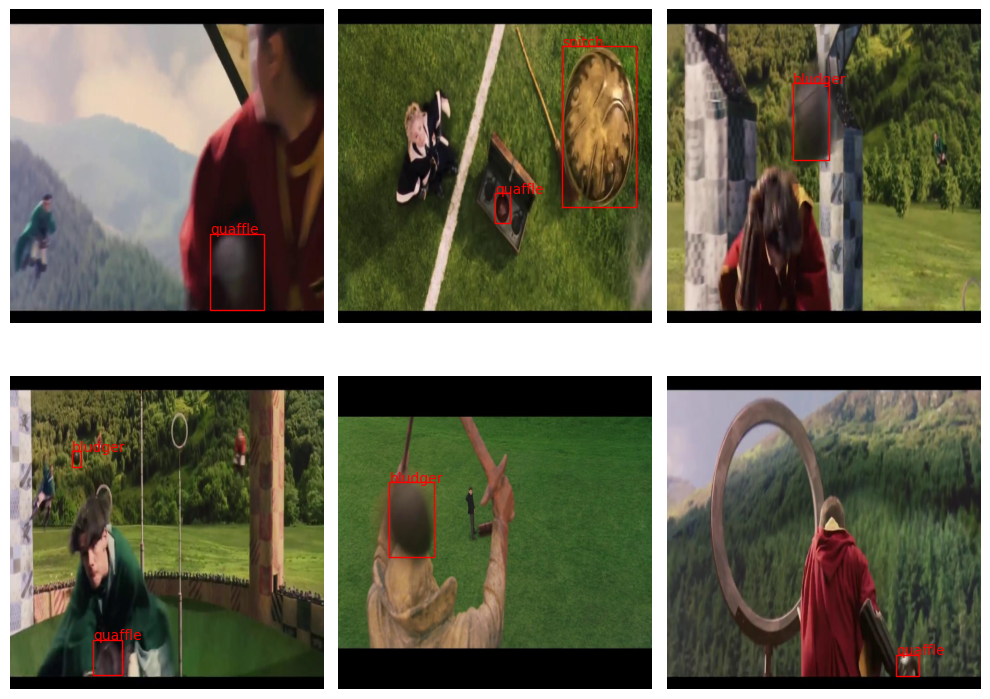

In [ ]:
out = [train_ds[i] for i in range(6)]
visualize([o["image"] for o in out], [o["bboxes"] for o in out])

# Шаг 3

Реализуем детектор, похожий на YOLO ([You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640)). Здесь мы его немного изменим и упростим. Будем использовать ResNet для извлечения признаков. На выходе мы будем получать карту признаков размера 16x16.

We convert lists of bounding boxes to the target downsampled grid. For this we

* compute centers of bounding boxes ($c_x, c_y$)
* change center coordinates (offset from the top left corner for each corresponding grid cell on a small grid)
* normalize box height and with to $[0, 1]$
* fill the target grid with values

## Шаг 3.1
Первым делом нам нужно реализовать collate function. Эта функция позволит нам кастомизировать, как именно батч конструируется из примеров

Эта функция принимает на вход лист прямоугольников и генерирует тензор размера Bx16x16x6. Первая размерность - это количество примеров в батче. Далее идут две пространственные размерности, это сетка 16 на 16.

В каналах у нас будут записаны:
* Сдвиги центра bbox относительно начала клеточки (клеточка это "пиксель" на изображении 16 на 16 на выходе сети). Записаны эти сдвиги будут в клеточку, к которой относятся. 2 канала (X, Y)
* Нормализованные ширина и высота bbox. 2 канала (W, H)
* Confidence сетки. Им мы будем пользоваться, чтобы фильтровать уверенность сетки в наличии bbox в данной клетке. Таргет содержит 1 там, где bbox есть, и 0 иначе. 1 канал
* Класс детекции (тот самый int, полученный из строки с названием)

In [ ]:
def collate_fn(batch, downsample=32):
    imgs, batch_boxes = map(list, (zip(*[(b["image"], b["bboxes"]) for b in batch])))

    imgs = torch.stack(imgs)
    b, _, h, w = imgs.shape

    target = imgs.new_zeros(b, 6, h // downsample, w // downsample)

    # Add sample index to targets
    for i, boxes in enumerate(batch_boxes):
        xmin, ymin, xmax, ymax, classes = map(
            torch.squeeze, torch.split(imgs.new_tensor(boxes), 1, dim=-1)
        )

        # Нормализуем ширину и высоту, поделив на ширину и высоту исходного изображения
        w_box = (xmax - xmin) / w # ширина бокса отнормированная
        h_box =  (ymax - ymin) / h # высота бокса отнормированная

        # Посчитаем координаты центра и сдвиги
        cx =  (xmin + xmax) / 2 # (координаты центра в исходных координатах)
        cy =  (ymin + ymax) / 2
        cx_idx =  (cx // downsample).to(torch.int64) # (посчитаем индекс центра на карте признаков размера 16x16. Это будут как раз координаты пикселя, куда мы запишем параметры коробки)
        cy_idx =  (cy // downsample).to(torch.int64)

        cx_box =  (cx - downsample*cx_idx)/downsample # (посчитаем сдивиги относительно cx_idx)
        cy_box =  (cy - downsample*cy_idx)/downsample

        target[i, :, cy_idx, cx_idx] = torch.stack(
            [cx_box, cy_box, w_box, h_box, torch.ones_like(cx_box), classes]
        )

    return {"image": imgs, "target": target}

Ниже выведем пример, как выглядит решетка размера 16 на 16 на исходном изображении:

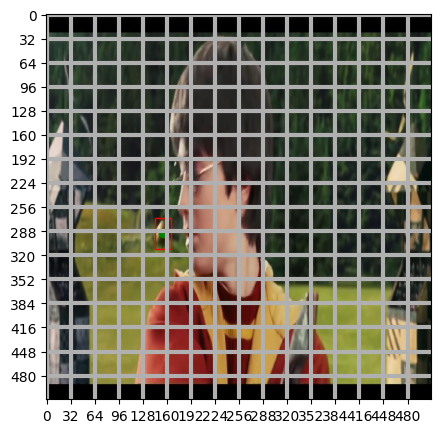

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
i = 20

img = train_ds[i]["image"].permute(1, 2, 0) * torch.tensor(std).view(
    1, 1, -1
) + torch.tensor(mean).view(1, 1, -1)
bboxes = torch.tensor(train_ds[i]["bboxes"])

ax.imshow(img)
loc = plt.matplotlib.ticker.MultipleLocator(base=32)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.grid(which="major", axis="both", linestyle="-", linewidth=3)

for bbox in bboxes:
    xmin, ymin, xmax, ymax = bbox[:-1]
    w = xmax - xmin
    h = ymax - ymin
    with_mask = bbox[-1]
    ax.add_patch(Rectangle((xmin, ymin), w, h, fill=False, color="red"))

cx = (bboxes[:, 0] + bboxes[:, 2]) / 2
cy = (bboxes[:, 1] + bboxes[:, 3]) / 2

ax.scatter(cx, cy, color="green", marker="o")

plt.show()

## Шаг 3.2

Выход нашей сетки будет несколько больше, чем Bx16x16x6. Почему?

Мы решаем задачу, где классов больше одного. Значит, у каждой клеточки из этих 16*16 будет свой вектор длины C, который мы будем использовать для определения класса.

Реализуем обратное относительно collate_fn преобразование, чтобы декодировать выход нейронной сети. Применив функцию decode_prediction к выходу collate function мы получим изначальный набор прямоугольников с корректными размерами и координатами, а также классами. Применив к выходу нейросети мы тоже получим набор прямоугольников и тоже с корректными классами.

In [ ]:
def decode_prediction(pred, upsample=32, threshold=0.7):
    b, c, h, w = pred.shape
    img_w, img_h = w * upsample, h * upsample
    bboxes = []
    for i in range(b): # пробегаем по каждой картинке батча предсказаний
        res = []
        for x_idx in range(h):
          for y_idx in range(w):
            if pred[i, 4, y_idx, x_idx] >= threshold: # проверяем что уверенность больше порога
              cx_idx = x_idx # координаты клетки, где все, что мы хотим
              cy_idx = y_idx

              cx = (pred[i, 0, y_idx, x_idx] + cx_idx) * upsample # находим центр бибокса в изначальных координатах
              cy = (pred[i, 1, y_idx, x_idx] + cy_idx) * upsample

              w_b = pred[i, 2, y_idx, x_idx] * img_w # пересчитываем норм длину и высоту бибокса
              h_b = pred[i, 3, y_idx, x_idx] * img_h # проверяем что уверенность больше порога

              x_min = cx - 0.5 * w_b # считаем координаты левого нижнего и правого верхнего углов
              y_min = cy - 0.5 * h_b

              x_max = cx + 0.5 * w_b
              y_max = cy + 0.5 * h_b

              # осталось самое сложное ;) вытянем класс
              if c == 6:
                class_b = pred[i, 5, y_idx, x_idx]
              else:
                class_b = torch.argmax((pred[i, 5:, y_idx, x_idx]))

              # собираем все что вытащили для этого бибокса в списочек
              res.append([x_min, y_min, x_max, y_max, class_b])

        # собираем информацию по всем бибоксам
        bboxes.append(res)
    return bboxes

## Шаг 3.3
Реализуем модель. Первым делом применим первые 4 блока (до layer4 включительно) ResNet50. Далее добавим несколько блоков (Conv2D, BatchNorm2D, ReLU). Постепенно будем уменьшать количество каналов до 5+C, а размер изображения до 16 на 16 (где С - количество классов в нашем датасете). Размер ядра при этом 3, паддинг 1. Так как все значения, которые мы предсказываем, находятся в отрезке от 0 до 1 (благодаря нормировке с клеточками), мы после финальной свертки еще применим сигмоиду. Для классов в такой постановке это не повредит.

In [ ]:
C =  3 # Количество классов


class Detector(nn.Module):
    def __init__(self):
        super().__init__()
        model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.resnet = nn.Sequential(*list(model.children())[:-2])  # Используем первые 4 блока ResNet50

        self.conv1 = nn.Conv2d(2048, 512, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(512)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(512, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(128, 32, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.relu3 = nn.ReLU()

        self.conv4 = nn.Conv2d(32, 5 + C, kernel_size=3, padding=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, img):
        x = self.resnet(img)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.conv4(x)

        return self.sigmoid(x)

## Шаг 3.4

Реализуем функцию потерь.

Для этого:
* Сделаем маску, которая будет говорить о положении детектируемых объектов
* Лосс похож на оригинальный для Yolo V1 и состоит из 4 частей (reduction='sum' для всех)
    - localization loss - Мы берем MSE по координатам бокса там, где есть детектируемый объект
    - box_loss - MSE от корней ширины и высоты bbox там, где есть детектируемый объект
    - classification_loss - Если детектируемый объект есть, то его кросс-энтропия по его классу
    - confidence_loss - Бинарная кросс-энтропия факта наличия объекта ДЛЯ ВСЕХ пикселей. Делается отдельно для детектируемых объектов (вес 1) и для недетектируемых (вес 0.1 например, поскольку их гораздо больше)

In [ ]:
def special_loss(pred, target, check=False, C=C):
    # Создаем масочку для клеток, где детектируемый объект есть
    mask = target[:, 4, :, :] > 0
    MSE = nn.MSELoss(reduction='sum')
    BCE = nn.BCELoss(reduction='sum')
    CEL = nn.CrossEntropyLoss(reduction='sum')

    # Считаем МСЕ по х и по у, применяя маску, суммируем эти 2 числа
    localization_loss = MSE(torch.masked_select(pred[:, 0, :, :], mask), torch.masked_select(target[:, 0, :, :], mask)) + \
    MSE(torch.masked_select(pred[:, 1, :, :], mask), torch.masked_select(target[:, 1, :, :], mask))

    # Считаем МСЕ от корней ширины и высоты bbox, применяя маску, суммируем эти 2 числа
    box_loss = MSE(torch.sqrt(torch.masked_select(pred[:, 2, :, :], mask)), torch.sqrt(torch.masked_select(target[:, 2, :, :], mask))) + \
    MSE(torch.sqrt(torch.masked_select(pred[:, 3, :, :], mask)), torch.sqrt(torch.masked_select(target[:, 3, :, :], mask)))

    # Считаем БСЕ для объектов с маской и без, вес с маской - 1, без - 0.1
    confidence_loss = BCE(torch.masked_select(pred[:, 4, :, :], mask),torch.masked_select(target[:, 4, :, :], mask)) + \
    BCE(torch.masked_select(pred[:, 4, :, :], ~mask),torch.masked_select(target[:, 4, :, :], ~mask)) * 0.1

    # Если детектируемый объект есть, то посчитаем его кросс-энтропию по его классу
    arr = []
    for clas in range(C):
      arr.append(torch.masked_select(pred[:, 5 + clas, :, :], mask))
    help =  torch.stack(arr, dim=1)
    targ = torch.masked_select(target[:, 5, :, :], mask)
    classification_loss = CEL(help, targ.long())

    if not check:
        return localization_loss + box_loss + classification_loss + confidence_loss

    else:
        return localization_loss, box_loss, classification_loss, confidence_loss

In [ ]:
# localization box classification confidence - возвращаются в таком порядке, можно сравнить
assert special_loss(torch.zeros((10, 8, 16, 16)), torch.ones((10, 8, 16, 16)), check=True, C=3) == (torch.tensor(5120.), torch.tensor(5120.), torch.tensor(2812.4465), torch.tensor(256000.))

# Шаг 4 Обучение модели


In [ ]:
loader = torch.utils.data.DataLoader(train_ds, 10, collate_fn=collate_fn)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(21)
EPOCHS = 20
model = Detector().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)

for e in tqdm(range(EPOCHS)):
    pbar = tqdm(loader, leave=False)
    epoch_losses = []
    for batch in pbar:
      # переносим все на один девайс
      images, targets = batch['image'].to(device), batch['target'].to(device)
      # очищаем градиенты
      opt.zero_grad()
      # делаем предсказания
      outputs = model(images)
      # вычисляем лосс
      loss = special_loss(outputs, targets)
      # обратное распр-е ошибки и обновление параметров
      loss.backward()
      opt.step()

      epoch_losses.append(loss.item())


    print(f"Epoch {e} done; Train loss {np.mean(epoch_losses):.3f};")

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 0 done; Train loss 91.489;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 1 done; Train loss 30.477;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 2 done; Train loss 18.632;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 3 done; Train loss 16.667;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 4 done; Train loss 14.280;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 5 done; Train loss 12.216;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 6 done; Train loss 10.414;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 7 done; Train loss 9.642;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 8 done; Train loss 9.281;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 9 done; Train loss 8.847;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 10 done; Train loss 8.209;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 11 done; Train loss 7.415;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 12 done; Train loss 6.973;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 13 done; Train loss 6.783;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 14 done; Train loss 6.593;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 15 done; Train loss 6.562;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 16 done; Train loss 6.518;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 17 done; Train loss 6.426;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 18 done; Train loss 6.308;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 19 done; Train loss 6.346;


Запустим обученный детектор на тестовых изображениях:

In [ ]:
test_loader = torch.utils.data.DataLoader(test_ds, 6, collate_fn=collate_fn)
i = iter(test_loader)
batch = next(i)

In [ ]:
# Сделаем предсказание и переложим результат на cpu
images, targets = batch['image'].to(device), batch['target'].to(device)
out = model(images).to(device)

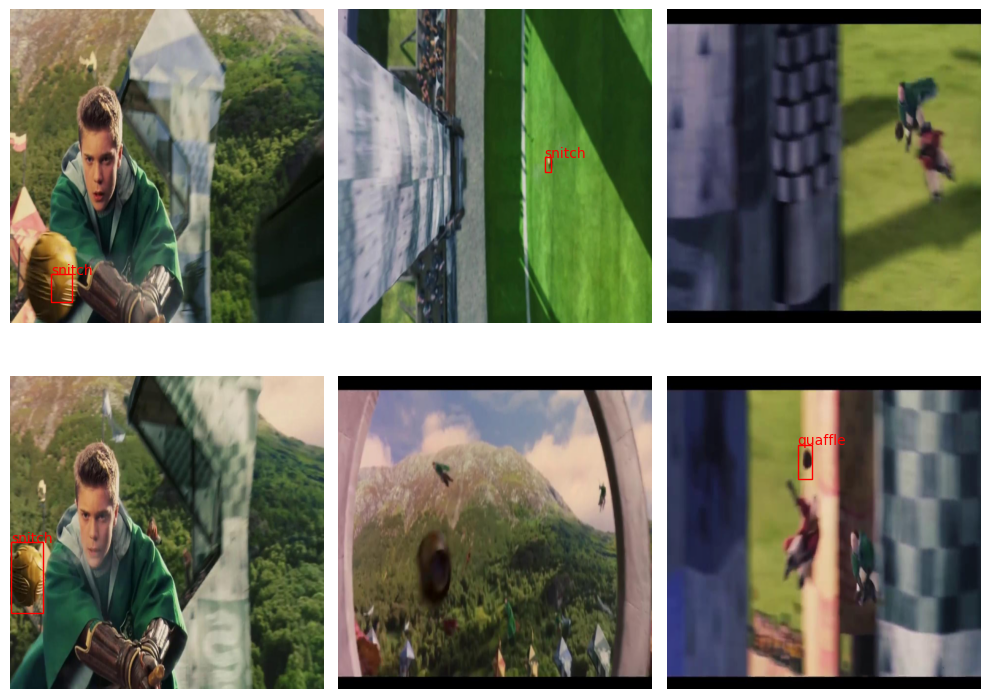

In [ ]:
# Сделаем визуализацию
visualize(images.detach().cpu(), decode_prediction(out.detach().cpu(), threshold=0.1))

# Шаг 5. Обучение готовой архитектуры

Для этого будем использовать YOLO v8 от ultralytics.

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 660.1/660.1 kB 5.4 MB/s eta 0:00:00


## Шаг 5.1

Чтобы дальше модель обучалась одной строкой, данные нужно переложить в правильный формат. Про правила для того, чтобы паковать данные можно посмотреть [тут](https://roboflow.com/formats/yolov8-pytorch-txt).

Если коротко:
* Есть .yaml, где живут пути к папкам с картинками, количество классов и их названия
* Есть папки train valid, в них две подпапки:
    - Первая images, в ней лежат картинки
    - Вторая labels, в ней лежат файлы с названиями как у картинок, но вместо расширения картинок нужен .txt, внутри формат как описан на Roboflow


In [ ]:
# Делаем папочки
!rm -rf train
!rm -rf valid
!mkdir -p train/images train/labels valid/images valid/labels

Реализуем функцию, которая принимает аннотации в изначальном формате, а возвращает их в нужном для YOLO v8. Это будет массив готовых строк, которые можно сразу забрасывать в файлик, добавив \n.

In [ ]:
def annotation2txt(bboxes, w_im, h_im):
    txt = []
    for bbox in bboxes:
        x_center = ((bbox[0]+bbox[2])/2)/w_im
        y_center = ((bbox[1]+bbox[3])/2)/h_im
        width = (bbox[2]-bbox[0])/w_im
        height = (bbox[3]-bbox[1])/h_im
        classs = bbox[4]
        txt.append(str(classs) + " "+ str(x_center) + " " + str(y_center) + " " + str(width) + " " + str(height))
    return txt

In [ ]:
# Копируем картиночки по папкам и создаем txt файлы

for i in range(len(train_ds)):
    result = train_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./train/images/" + result[0].split("/")[-1],
    )

    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./train/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

for i in range(len(test_ds)):
    result = test_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./valid/images/" + result[0].split("/")[-1],
    )
    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./valid/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

In [ ]:
# Собираем YAML

nc = 3 # Укажем число классов
names = ["snitch", "quaffle", "bludger"] # Укажем имена классов

with open("data.yaml", "w") as f:
    f.write(f"train: ../train/images\nval: ../valid/images\n\nnc: {nc}\nnames: {names}")

In [ ]:
#with open("./data/class_dict", 'r') as f:
  #print(f.read())

## Шаг 5.2

Обучим модель YOLO v8 самого маленького размера.

In [ ]:
import ultralytics
from ultralytics import YOLO

# Load the model.
model = YOLO('yolov8n.yaml')

# Training.
results = model.train(
   data='data.yaml',
   epochs=100,
   batch=8,
   imgsz=512
)


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

100%|██████████| 755k/755k [00:00<00:00, 16.0MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 46.3MB/s]


AMP: checks passed ✅


train: Scanning /content/train/labels... 254 images, 0 backgrounds, 0 corrupt: 100%|██████████| 254/254 [00:00<00:00, 1348.02it/s]


train: New cache created: /content/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/valid/labels... 29 images, 0 backgrounds, 0 corrupt: 100%|██████████| 29/29 [00:00<00:00, 553.27it/s]

val: New cache created: /content/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      8.88G      4.967      12.08      4.172         15        512: 100%|██████████| 32/32 [00:07<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]

                   all         29         35   9.19e-05     0.0556   8.86e-05   8.86e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      7.36G      4.866      9.859       4.07         12        512: 100%|██████████| 32/32 [00:07<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.81it/s]

                   all         29         35   0.000209     0.0556   0.000154   3.08e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      7.37G      4.188      7.153      3.803         13        512: 100%|██████████| 32/32 [00:05<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.18it/s]

                   all         29         35   0.000454     0.0556   0.000269   5.38e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      7.37G      3.682       6.74      3.404         12        512: 100%|██████████| 32/32 [00:07<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.28it/s]

                   all         29         35   0.000454     0.0556   0.000269   5.38e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      7.37G       3.71       6.57      3.041         13        512: 100%|██████████| 32/32 [00:05<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.03it/s]

                   all         29         35   0.000624      0.119    0.00239   0.000698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      7.37G      3.308      5.651      2.909         16        512: 100%|██████████| 32/32 [00:07<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.14it/s]

                   all         29         35      0.668     0.0159   0.000723   0.000278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      7.37G      3.078      5.225      2.527         11        512: 100%|██████████| 32/32 [00:05<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.14it/s]

                   all         29         35    0.00216      0.282      0.011    0.00385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      7.37G      3.047      4.778      2.538         13        512: 100%|██████████| 32/32 [00:06<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.48it/s]

                   all         29         35      0.678     0.0159    0.00973    0.00332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      7.37G       2.94      4.618      2.421          9        512: 100%|██████████| 32/32 [00:05<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.73it/s]

                   all         29         35     0.0024      0.454     0.0107    0.00302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      7.37G      2.865      4.382      2.271          9        512: 100%|██████████| 32/32 [00:08<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.76it/s]

                   all         29         35      0.713     0.0317     0.0248    0.00759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      7.37G      2.803      4.137      2.219         10        512: 100%|██████████| 32/32 [00:05<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.20it/s]

                   all         29         35      0.484     0.0794     0.0773     0.0288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      7.37G      2.716      3.975      2.174         14        512: 100%|██████████| 32/32 [00:07<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]

                   all         29         35      0.912     0.0556      0.115     0.0426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      7.37G      2.672      3.868      2.137         16        512: 100%|██████████| 32/32 [00:05<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.45it/s]

                   all         29         35      0.498      0.103      0.114     0.0549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      7.37G      2.586      3.549      2.084         13        512: 100%|██████████| 32/32 [00:06<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]

                   all         29         35      0.587     0.0709      0.112     0.0657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      7.37G      2.561      3.558      2.008         10        512: 100%|██████████| 32/32 [00:05<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.19it/s]

                   all         29         35      0.473      0.103      0.177     0.0615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      7.37G       2.59       3.57      2.017         12        512: 100%|██████████| 32/32 [00:06<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.29it/s]

                   all         29         35      0.158     0.0873      0.127     0.0644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      7.37G      2.554      3.383      1.997         11        512: 100%|██████████| 32/32 [00:05<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.45it/s]

                   all         29         35      0.741      0.084      0.156     0.0875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      7.37G       2.42      3.243      1.854         11        512: 100%|██████████| 32/32 [00:06<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.34it/s]

                   all         29         35      0.191      0.222      0.191     0.0856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      7.37G      2.415      3.085      1.913         16        512: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.45it/s]

                   all         29         35      0.544      0.143      0.152     0.0916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      7.37G      2.337      3.063      1.754          9        512: 100%|██████████| 32/32 [00:05<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.66it/s]

                   all         29         35      0.642      0.167       0.19     0.0776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      7.37G      2.256      2.927        1.8         11        512: 100%|██████████| 32/32 [00:06<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.70it/s]

                   all         29         35      0.329      0.133      0.193      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      7.37G      2.336      2.891      1.831         14        512: 100%|██████████| 32/32 [00:05<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.64it/s]

                   all         29         35      0.487      0.156      0.211     0.0948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      7.37G      2.321      2.872      1.866         13        512: 100%|██████████| 32/32 [00:06<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.00it/s]

                   all         29         35      0.255      0.211      0.263      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      7.37G       2.33      2.768      1.824         11        512: 100%|██████████| 32/32 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.49it/s]

                   all         29         35      0.272      0.264      0.275      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      7.37G       2.27      2.659      1.771         17        512: 100%|██████████| 32/32 [00:06<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]

                   all         29         35      0.758      0.175      0.215      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      7.37G      2.222      2.517      1.756         12        512: 100%|██████████| 32/32 [00:05<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.64it/s]

                   all         29         35      0.716      0.254      0.295       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      7.37G      2.272      2.645      1.756          9        512: 100%|██████████| 32/32 [00:07<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.27it/s]

                   all         29         35      0.313      0.327      0.328      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      7.37G      2.083      2.517      1.629         10        512: 100%|██████████| 32/32 [00:05<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.29it/s]

                   all         29         35      0.645       0.19      0.259      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      7.37G        2.1      2.429      1.697          7        512: 100%|██████████| 32/32 [00:07<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.94it/s]


                   all         29         35      0.306      0.236      0.277      0.159

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      7.37G      2.133      2.398      1.655         10        512: 100%|██████████| 32/32 [00:05<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.39it/s]

                   all         29         35      0.312      0.327      0.315      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      7.37G      2.096      2.435      1.689         12        512: 100%|██████████| 32/32 [00:07<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.75it/s]


                   all         29         35      0.376       0.31      0.343      0.208

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      7.37G      2.073      2.337      1.601         11        512: 100%|██████████| 32/32 [00:05<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]

                   all         29         35      0.366      0.281      0.352      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      7.37G      2.043      2.185       1.56         11        512: 100%|██████████| 32/32 [00:07<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.29it/s]

                   all         29         35      0.375      0.314      0.355      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      7.37G      1.982      2.164      1.567         17        512: 100%|██████████| 32/32 [00:05<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.88it/s]

                   all         29         35      0.599      0.413       0.41      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      7.37G      2.006      2.153      1.543         19        512: 100%|██████████| 32/32 [00:06<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.38it/s]

                   all         29         35      0.464      0.448       0.41      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      7.37G      2.024      2.194      1.628         15        512: 100%|██████████| 32/32 [00:05<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.02it/s]

                   all         29         35      0.423      0.322      0.381      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      7.37G      1.951      2.088      1.548         10        512: 100%|██████████| 32/32 [00:06<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.32it/s]

                   all         29         35       0.46      0.377      0.352      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      7.37G      2.005      2.121      1.572          9        512: 100%|██████████| 32/32 [00:05<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.28it/s]

                   all         29         35       0.31       0.26      0.334      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      7.37G      1.957        2.1      1.548         11        512: 100%|██████████| 32/32 [00:06<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.54it/s]

                   all         29         35      0.515      0.383      0.428      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      7.37G       1.94      2.061      1.528         10        512: 100%|██████████| 32/32 [00:05<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.45it/s]

                   all         29         35      0.517      0.351      0.427      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      7.37G       1.85      1.869      1.432          8        512: 100%|██████████| 32/32 [00:05<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.77it/s]

                   all         29         35      0.431       0.28      0.359      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      7.37G      1.889      1.914      1.491          9        512: 100%|██████████| 32/32 [00:06<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.78it/s]

                   all         29         35      0.491      0.417      0.408      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      7.37G      1.838      1.823      1.474         17        512: 100%|██████████| 32/32 [00:05<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.95it/s]

                   all         29         35      0.609      0.364      0.477      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      7.37G      1.894       1.96      1.488          8        512: 100%|██████████| 32/32 [00:07<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

                   all         29         35      0.593      0.369      0.461      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      7.37G      1.831      1.954      1.465         15        512: 100%|██████████| 32/32 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.54it/s]

                   all         29         35        0.8      0.297      0.468      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      7.37G      1.794      1.796       1.42         13        512: 100%|██████████| 32/32 [00:07<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.28it/s]

                   all         29         35      0.704       0.44      0.494      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      7.37G      1.748      1.696      1.381         18        512: 100%|██████████| 32/32 [00:05<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.37it/s]


                   all         29         35      0.553      0.393      0.491      0.313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      7.37G      1.868      1.832      1.438         11        512: 100%|██████████| 32/32 [00:07<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.86it/s]

                   all         29         35      0.885      0.474      0.589      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      7.37G      1.813      1.816      1.415          6        512: 100%|██████████| 32/32 [00:05<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.59it/s]

                   all         29         35       0.73      0.344      0.489      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      7.37G      1.761      1.743      1.427          8        512: 100%|██████████| 32/32 [00:07<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.23it/s]


                   all         29         35      0.672      0.389       0.52      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      7.37G      1.759      1.723      1.402         12        512: 100%|██████████| 32/32 [00:05<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.02it/s]


                   all         29         35       0.63      0.439      0.511      0.337

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      7.37G      1.711      1.605      1.329         16        512: 100%|██████████| 32/32 [00:06<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.65it/s]

                   all         29         35      0.758      0.389      0.486      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      7.37G      1.867      1.825       1.46         14        512: 100%|██████████| 32/32 [00:05<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]

                   all         29         35      0.607      0.351      0.466      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      7.37G      1.727      1.692      1.383         10        512: 100%|██████████| 32/32 [00:06<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.73it/s]

                   all         29         35       0.45      0.425      0.463      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      7.37G      1.815      1.691      1.397         12        512: 100%|██████████| 32/32 [00:05<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.96it/s]

                   all         29         35      0.731      0.409      0.491      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      7.37G      1.852      1.724      1.401          8        512: 100%|██████████| 32/32 [00:05<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.65it/s]

                   all         29         35      0.762      0.393      0.505       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      7.37G      1.739      1.691      1.375         11        512: 100%|██████████| 32/32 [00:06<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.46it/s]

                   all         29         35       0.64      0.363      0.492      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      7.37G      1.749      1.678      1.358          9        512: 100%|██████████| 32/32 [00:05<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]

                   all         29         35      0.698      0.409      0.521      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      7.37G      1.675      1.731      1.397         18        512: 100%|██████████| 32/32 [00:06<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.44it/s]


                   all         29         35      0.784      0.425      0.541      0.328

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      7.37G      1.711      1.631      1.386         12        512: 100%|██████████| 32/32 [00:05<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.37it/s]

                   all         29         35      0.831        0.4      0.554      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      7.37G      1.732      1.635       1.43          6        512: 100%|██████████| 32/32 [00:07<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.86it/s]

                   all         29         35      0.872      0.406       0.57      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      7.37G      1.647      1.535      1.363         14        512: 100%|██████████| 32/32 [00:05<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.17it/s]

                   all         29         35      0.809      0.377      0.505      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      7.37G      1.659        1.6      1.379         13        512: 100%|██████████| 32/32 [00:07<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.45it/s]

                   all         29         35      0.803      0.361      0.546      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      7.37G      1.711       1.59      1.417         12        512: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]

                   all         29         35      0.833      0.385      0.577      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      7.37G      1.733      1.616      1.351          6        512: 100%|██████████| 32/32 [00:07<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.63it/s]

                   all         29         35       0.55      0.481      0.542      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      7.37G      1.678      1.556      1.307         14        512: 100%|██████████| 32/32 [00:05<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.63it/s]

                   all         29         35      0.366      0.583      0.481      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      7.37G      1.689      1.587      1.386         19        512: 100%|██████████| 32/32 [00:06<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]

                   all         29         35      0.668      0.395      0.545      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      7.37G       1.62      1.481      1.326         10        512: 100%|██████████| 32/32 [00:05<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.25it/s]

                   all         29         35      0.722      0.413      0.547       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      7.37G      1.648      1.534      1.322          9        512: 100%|██████████| 32/32 [00:06<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.53it/s]

                   all         29         35      0.451      0.538      0.545      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      7.37G      1.616      1.516      1.342          9        512: 100%|██████████| 32/32 [00:05<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.13it/s]

                   all         29         35      0.803      0.395      0.541      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      7.37G      1.602      1.494      1.304         12        512: 100%|██████████| 32/32 [00:05<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.65it/s]

                   all         29         35      0.792      0.446      0.614      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      7.37G      1.594      1.509      1.269         11        512: 100%|██████████| 32/32 [00:05<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.88it/s]

                   all         29         35      0.595      0.591      0.609      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      7.37G      1.618      1.481      1.328         10        512: 100%|██████████| 32/32 [00:05<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]

                   all         29         35      0.519      0.572      0.619      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      7.37G      1.574      1.431      1.275         14        512: 100%|██████████| 32/32 [00:06<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.21it/s]

                   all         29         35      0.646      0.526      0.611      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      7.37G       1.54      1.386      1.261         15        512: 100%|██████████| 32/32 [00:05<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.16it/s]

                   all         29         35      0.528      0.593      0.598      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      7.37G      1.543      1.331      1.268          9        512: 100%|██████████| 32/32 [00:07<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.85it/s]

                   all         29         35      0.667      0.498      0.619      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      7.37G      1.629       1.43      1.302         15        512: 100%|██████████| 32/32 [00:05<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.72it/s]

                   all         29         35      0.656      0.613      0.637      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      7.37G      1.674      1.409      1.335         12        512: 100%|██████████| 32/32 [00:07<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]

                   all         29         35      0.656      0.575      0.615      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      7.37G      1.543      1.409      1.294         11        512: 100%|██████████| 32/32 [00:05<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.27it/s]

                   all         29         35       0.79      0.583      0.657      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      7.37G      1.526      1.406      1.281         15        512: 100%|██████████| 32/32 [00:07<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.87it/s]

                   all         29         35      0.741      0.581      0.663      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      7.37G       1.58      1.381      1.303         11        512: 100%|██████████| 32/32 [00:05<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


                   all         29         35      0.741      0.543       0.67      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      7.37G       1.52      1.278      1.228         15        512: 100%|██████████| 32/32 [00:07<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.79it/s]

                   all         29         35      0.737      0.552      0.659      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      7.37G      1.471      1.248      1.281         13        512: 100%|██████████| 32/32 [00:05<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.65it/s]

                   all         29         35      0.673      0.553      0.671      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      7.37G       1.58      1.366      1.283         10        512: 100%|██████████| 32/32 [00:07<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.29it/s]

                   all         29         35      0.742      0.562      0.668      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      7.37G      1.462      1.288      1.271         14        512: 100%|██████████| 32/32 [00:05<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.26it/s]


                   all         29         35      0.705      0.564      0.704      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      7.37G      1.552      1.259      1.243         14        512: 100%|██████████| 32/32 [00:07<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.74it/s]

                   all         29         35      0.862      0.545      0.717      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      7.37G      1.443      1.206      1.186         14        512: 100%|██████████| 32/32 [00:05<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.15it/s]

                   all         29         35      0.904      0.533      0.724      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      7.37G       1.42      1.247      1.237         11        512: 100%|██████████| 32/32 [00:06<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.76it/s]

                   all         29         35      0.827      0.552      0.705      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      7.37G      1.435      1.186      1.247         12        512: 100%|██████████| 32/32 [00:05<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.84it/s]

                   all         29         35      0.775      0.564      0.678      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      7.37G      1.432      1.243      1.255          7        512: 100%|██████████| 32/32 [00:06<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.39it/s]

                   all         29         35      0.791      0.567      0.707      0.486


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      7.36G      1.471      1.507      1.265         10        512: 100%|██████████| 32/32 [00:06<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.24it/s]

                   all         29         35      0.709      0.564      0.692      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      7.37G      1.546      1.485      1.271          7        512: 100%|██████████| 32/32 [00:06<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.69it/s]

                   all         29         35      0.681      0.594      0.703      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      7.37G      1.513      1.405       1.31          7        512: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.79it/s]

                   all         29         35      0.658      0.649      0.743      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      7.37G      1.528      1.404      1.301          6        512: 100%|██████████| 32/32 [00:06<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.29it/s]

                   all         29         35      0.752      0.672      0.773      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      7.37G      1.398       1.31      1.227          6        512: 100%|██████████| 32/32 [00:06<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.67it/s]

                   all         29         35       0.68      0.754      0.755      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      7.37G      1.415       1.26      1.201          9        512: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.70it/s]

                   all         29         35      0.738      0.641       0.74       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      7.37G      1.455      1.358      1.253          7        512: 100%|██████████| 32/32 [00:06<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.40it/s]

                   all         29         35      0.631      0.638      0.739      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      7.36G      1.422       1.22      1.206          6        512: 100%|██████████| 32/32 [00:05<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.44it/s]

                   all         29         35      0.778      0.597      0.735      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      7.37G      1.394      1.325      1.205          9        512: 100%|██████████| 32/32 [00:07<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.32it/s]

                   all         29         35      0.736      0.628      0.733      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      7.37G      1.408      1.208      1.243          6        512: 100%|██████████| 32/32 [00:05<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]

                   all         29         35      0.797      0.607      0.745      0.457



100 epochs completed in 0.202 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.0.225 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]


                   all         29         35      0.904      0.533      0.724      0.485
                snitch         29          6      0.946      0.833      0.931      0.566
               quaffle         29         21          1      0.515      0.808      0.576
               bludger         29          8      0.766       0.25      0.432      0.313
Speed: 0.7ms preprocess, 2.2ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/train


## Шаг 5.3

Отрисуем предсказания на валидационной выборке

In [ ]:
model = YOLO('runs/detect/train/weights/best.pt')  # загрузим собственную модель

# Сделаем предсказание с помощью модели
results = model(data='data.yaml', source='/content/valid/images', save=True)


image 1/29 /content/valid/images/100.jpg: 256x512 1 quaffle, 58.6ms
image 2/29 /content/valid/images/11.jpg: 256x512 1 bludger, 8.0ms
image 3/29 /content/valid/images/111.jpg: 256x512 1 bludger, 8.4ms
image 4/29 /content/valid/images/114.jpg: 256x512 (no detections), 12.2ms
image 5/29 /content/valid/images/116.jpg: 256x512 (no detections), 7.8ms
image 6/29 /content/valid/images/155.jpg: 256x512 1 quaffle, 8.0ms
image 7/29 /content/valid/images/163.jpg: 288x512 1 snitch, 55.6ms
image 8/29 /content/valid/images/165.jpg: 256x512 (no detections), 9.2ms
image 9/29 /content/valid/images/172.jpg: 256x512 1 quaffle, 8.0ms
image 10/29 /content/valid/images/174.jpg: 256x512 1 quaffle, 9.4ms
image 11/29 /content/valid/images/175.jpg: 256x512 (no detections), 8.1ms
image 12/29 /content/valid/images/180.jpg: 256x512 1 quaffle, 8.9ms
image 13/29 /content/valid/images/191.jpg: 256x512 (no detections), 8.3ms
image 14/29 /content/valid/images/200.jpg: 256x512 1 quaffle, 8.4ms
image 15/29 /content/vali

In [ ]:
from PIL import Image
img1 = Image.open('runs/detect/predict/100.jpg')
img2 = Image.open('runs/detect/predict/11.jpg')
img3 = Image.open('runs/detect/predict/111.jpg')
img4 = Image.open('runs/detect/predict/114.jpg')
img5 = Image.open('runs/detect/predict/116.jpg')
img6 = Image.open('runs/detect/predict/155.jpg')


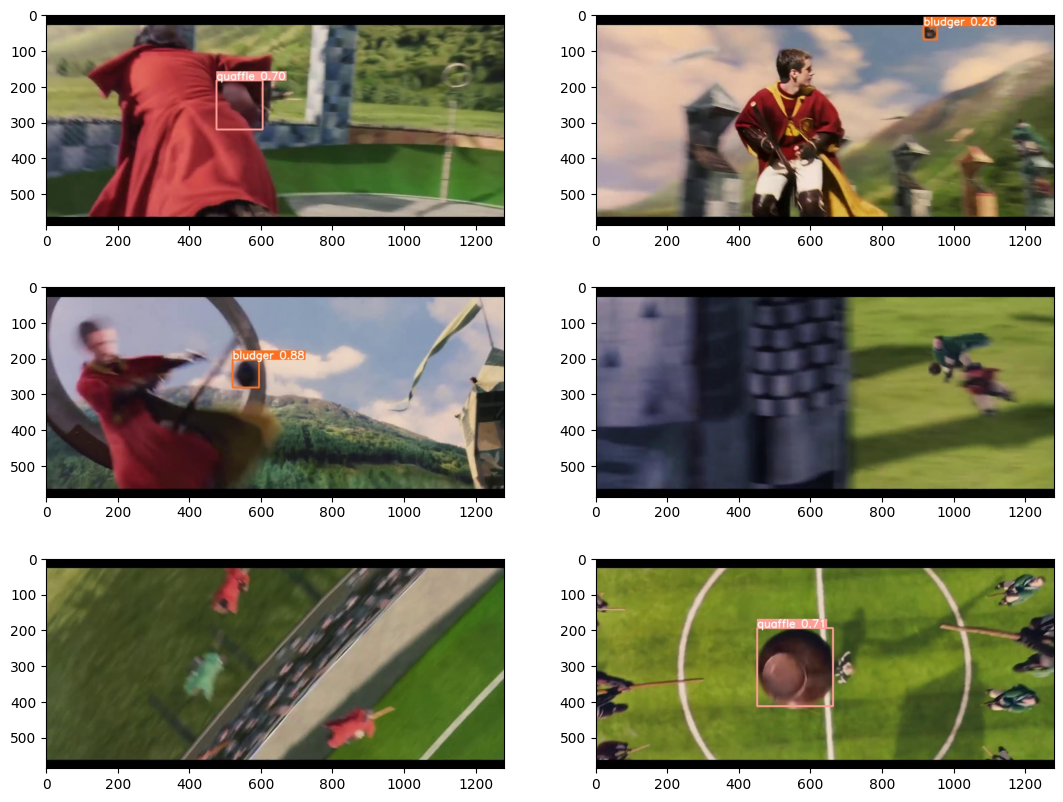

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(13, 10))
axs[0, 0].imshow(img1)
axs[0, 1].imshow(img2)
axs[1, 0].imshow(img3)
axs[1, 1].imshow(img4)
axs[2, 0].imshow(img5)
axs[2, 1].imshow(img6)

plt.show()